# Fashion MNIST 
The MNIST dataset contains 70000 images of handwritten digits from 0-9. It is a very popular dataset and is commonly used to benchmark the accuracy of computer vision models. Some claim that for modern computer vision tasks the dataset is too easy to learn and is not a good indicator for how accurate a model really is. The Fashion MNIST dataset is used a drop-in replacement for MNIST and is meant to be a much more difficult dataset to classify. 

From github.com/zalandoresearch

> _Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits._

For more information see - https://github.com/zalandoresearch/fashion-mnist

### Import modules and create CAS session
- In this code we import the needed modules and cas action sets
- We assign values for the cashost, casport, and casauth values 
- These are then used to establish a CAS session named 's'
- Documentation to [Connect and Start a Session](http://go.documentation.sas.com/?cdcId=pgmsascdc&cdcVersion=9.4_3.3&docsetId=caspg3&docsetTarget=home.htm&locale=en)

In [1]:
%matplotlib inline
from collections import OrderedDict
import swat as sw
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display

from casplt import plot_imgs

# Start CAS session
sw.options.cas.print_messages = False
s = sw.CAS('localhost', 5570, 'sas','pwd')
s.loadactionset('image')
s.loadactionset('deepLearn')
s.loadactionset('sampling')

sns.set()

class_dict = OrderedDict([('class0','T-shirt/top'), ('class1','Trouser'), ('class2','Pullover'), ('class3','Dress'), 
                          ('class4','Coat'),('class5','Sandal'), ('class6','Shirt'), ('class7','Sneaker'), 
                          ('class8','Bag'), ('class9','Ankle boot')])

### Load data into CAS and partition
- Load and decode images recursively into CAS. 
- Single channel images divided into 10 diffferent classes

In [2]:
# Load training images recursively 
s.image.loadimages(casout=dict(name='train', blocksize='128',replace=True), recurse=True, decode=True, 
                   distribution="RANDOM", labelLevels=1, path='/some/dir/mnist_fashion_train_png/')
# Load test images recursively 
s.image.loadimages(casout=dict(name='test', blocksize='128',replace=True), recurse=True, decode=True,
                   distribution="RANDOM", labelLevels=1, path='/some/dir/mnist_fashion_test_png/')
s.image.summarizeimages(imagetable='train')['Summary']

,Column,png,minWidth,maxWidth,minHeight,maxHeight,meanWidth,meanHeight,mean1stChannel,min1stChannel,max1stChannel,mean2ndChannel,min2ndChannel,max2ndChannel,mean3rdChannel,min3rdChannel,max3rdChannel
0,_image_,59907.0,28.0,28.0,28.0,28.0,28.0,28.0,73.002725,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Partition training images into train and validation sets using stratified sampling with an 80/20 split
- Training set has PartInd = 0 
- Validation set has PartInd = 1

In [3]:
s.stratified(display={"names":"STRAFreq"},
                 output={"casOut":{"name":"train", "replace":True}, "copyVars":"ALL"},
                 samppct=20, partind=True, seed=10,
                 table={"name":"train"},
                 outputTables={"names":{"STRAFreq"},"replace":True})

,ByGrpID,NObs,NSamp
0,0,59907,11981


##### Create CASTable (in-memory table) from loaded images and shuffle 

In [4]:
trainTbl = s.CASTable('train', replace=True)
testTbl= s.CASTable('test',replace=True)
trainTbl.shuffle(casout=dict(name=trainTbl,replace=True), table=trainTbl)
testTbl.shuffle(casout=dict(name=testTbl,replace=True), table=testTbl)

[caslib]

 u'CASUSER(sas)'

[tableName]

 u'TEST'

[casTable]

 CASTable(u'TEST', caslib=u'CASUSER(sas)')

+ Elapsed: 0.0182s, user: 0.0103s, sys: 0.00785s, mem: 22.1mb

### Summerize CASTables and examine partitions  

##### Additional column _PartInd_ now included in CASTable

In [5]:
trainTbl.columninfo()

,Column,Label,ID,Type,RawLength,FormattedLength,NFL,NFD
0,_dimension_,,1,int64,8,12,0,0
1,_resolution_,,2,varbinary,16,16,0,0
2,_imageFormat_,,3,int64,8,12,0,0
3,_image_,,4,varbinary,784,784,0,0
4,_size_,,5,int64,8,12,0,0
5,_path_,,6,varchar,65,65,0,0
6,_label_,,7,varchar,6,6,0,0
7,_type_,,8,char,3,3,0,0
8,_id_,,9,int64,8,12,0,0
9,_PartInd_,Partition Indicator,10,double,8,12,0,0


##### Frequncy of observations for both _PartInd_ values 

In [6]:
trainTbl.freq(inputs='_PartInd_')

,Column,NumVar,FmtVar,Level,Frequency
0,_PartInd_,0.0,0,1,47926.0
1,_PartInd_,1.0,1,2,11981.0


##### First 5 observations in CASTable

In [ ]:
trainTbl.head()

### Plot sample images from each class
    Class Description
    0   T-shirt/top
    1   Trouser
    2   Pullover
    3   Dress
    4   Coat
    5   Sandal
    6   Shirt
    7   Sneaker
    8   Bag
    9   Ankle boot

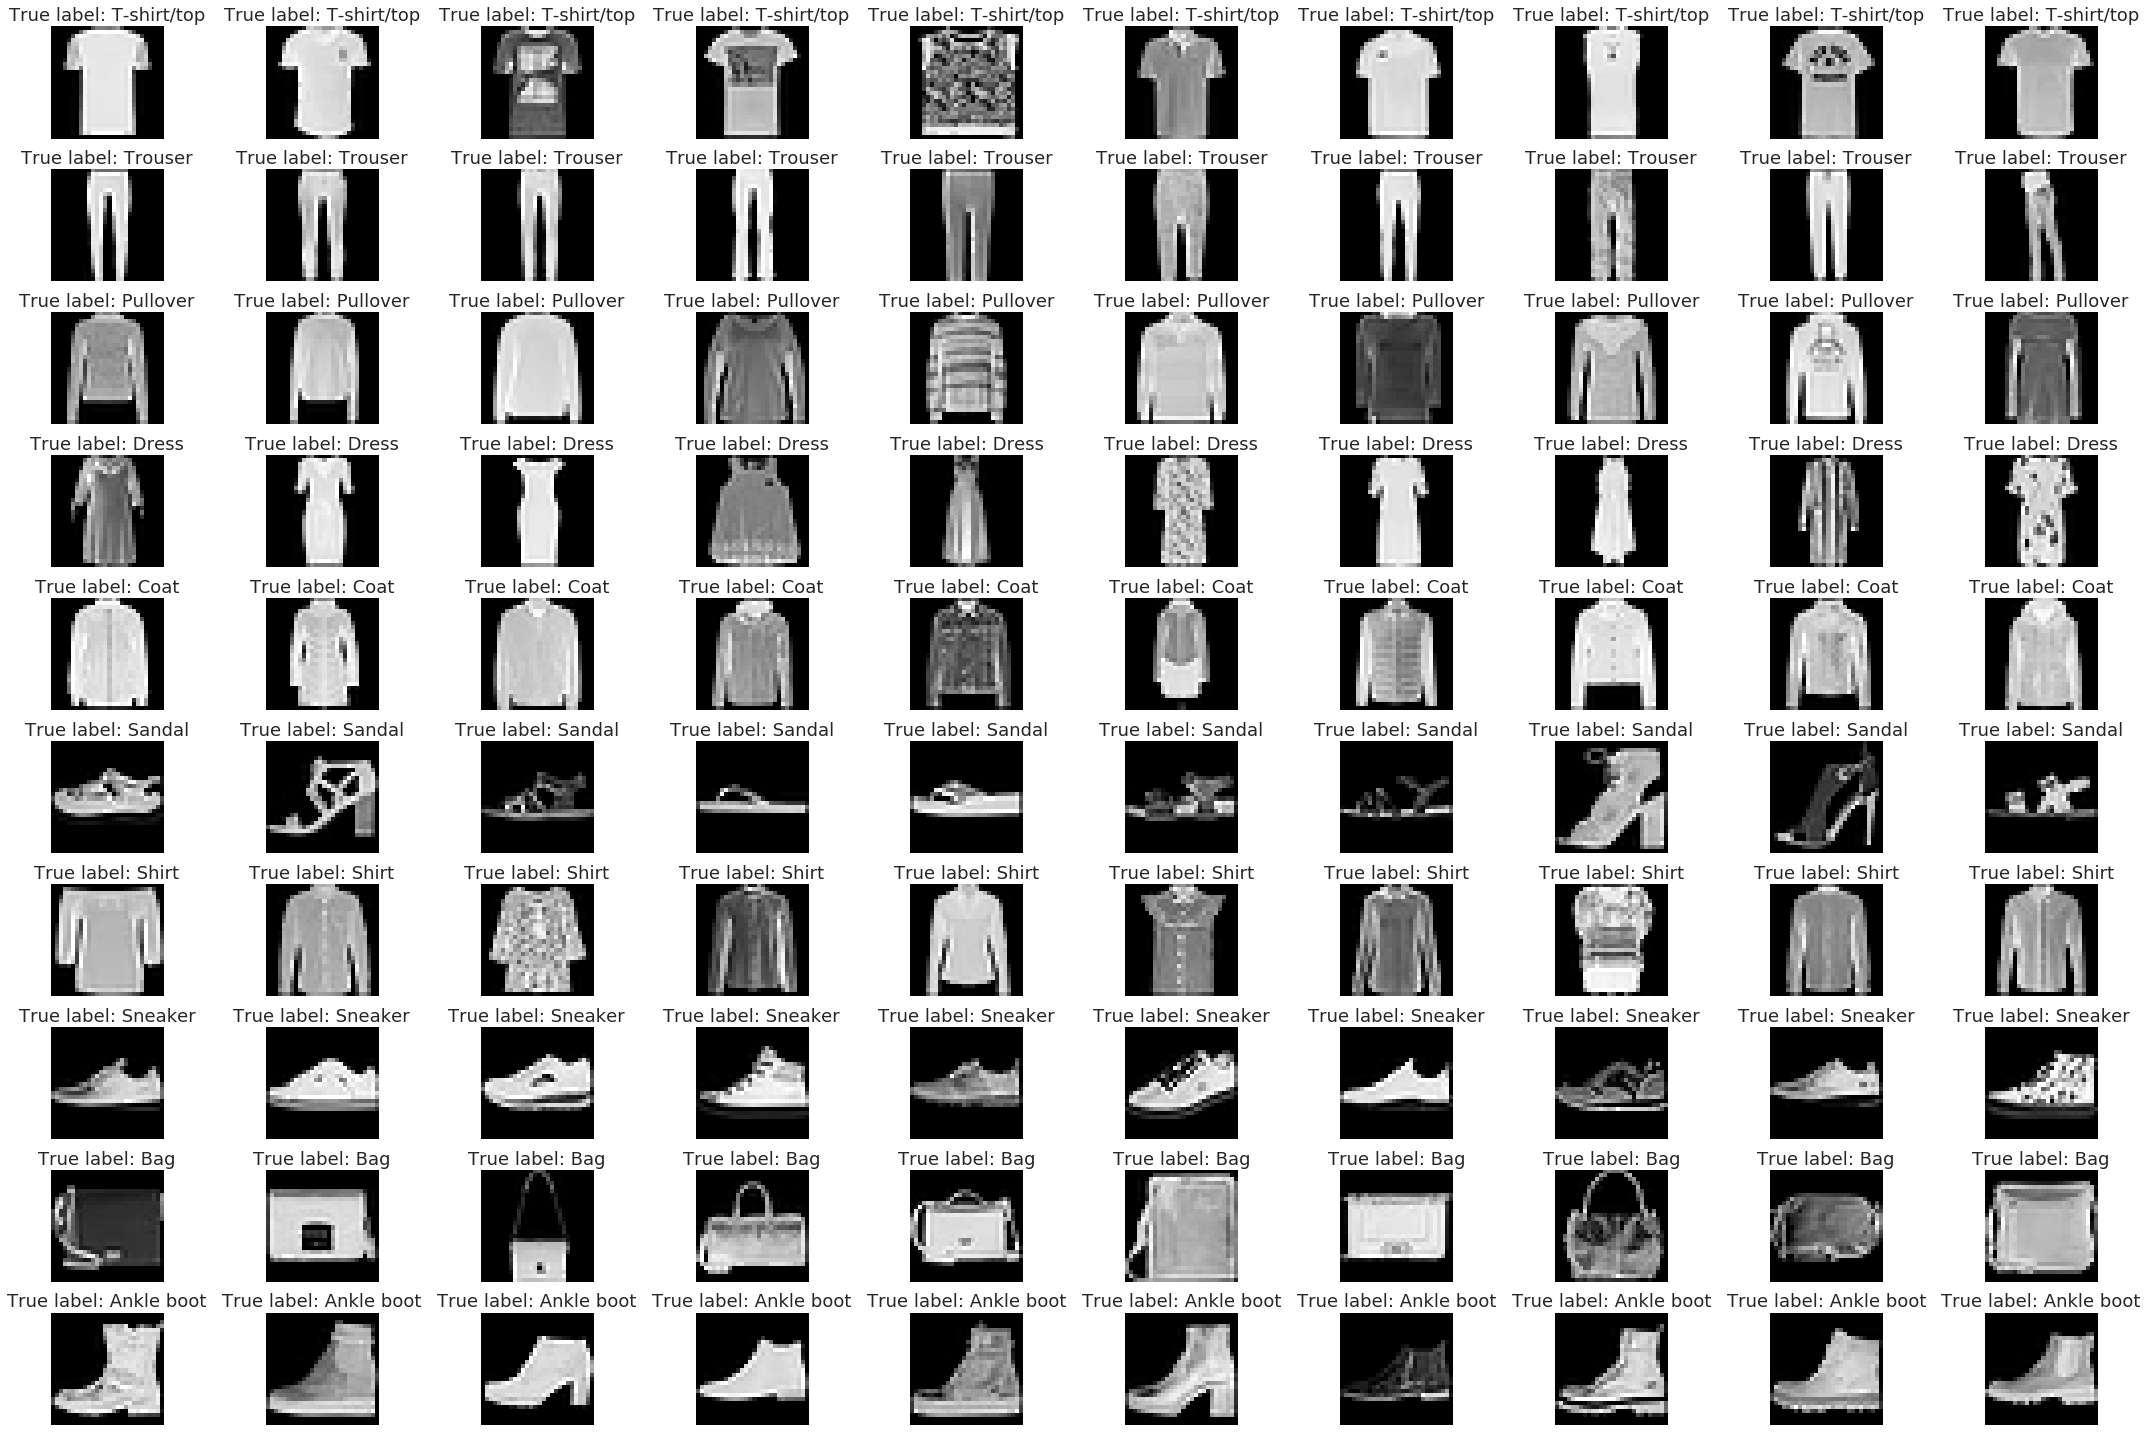

In [8]:
plot_imgs(trainTbl, images_per_class=10, figsize=(30,20), font_size=18)

### Create model architecture 

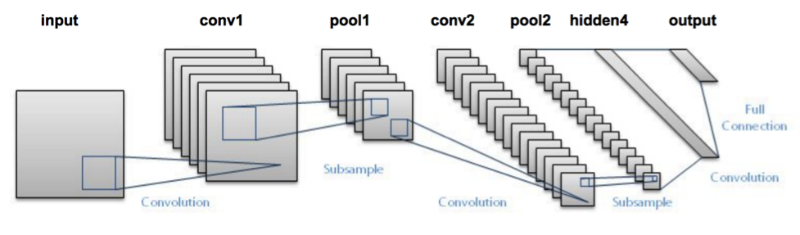

In [9]:
display(Image(filename='some/dir/lenet_architecture.png', embed=True))

Define the model architecture by subsequently adding layers to the model object. The model is a type of ConvNet called LeNet which consist of mainly 3 types of layers - convolution, pooling, and fully connected. The model can be made arbitrarily deep by repeating the sequence of convolution to pooling layers, but in this instance we only use 2 convolutional layers to keep the number of parameters down. 

As each layer is built you must specify some options and hyperparameters. These options and hyperparamaters are layer dependent. For example the first layer, data, specifies the image dimensions as well as some image augmentation and normalization options. One option in the data layer is image standardization (std='STD') where an 'average' image is created (0 mean, 1 std). There is also a scale value specified which normalizes the pixel values of our image to be between 0 and 1 (0.004 = 1/255).

Following the input layer the first convolutional layer is created. Hyperparameters for this layer like number of filters, filter size, stride, weight initialization method, and activation function are assigned. Aside from the standard activation functions (tanh, relu, etc.) you can also [define your own activation functions](http://go.documentation.sas.com/?cdcId=pgmsascdc&cdcVersion=9.4_3.3&docsetId=casdlpg&docsetTarget=n05z4t47t5g95xn18sp25xwdqs70.htm&locale=en#n0z6vluxdfvg0an1f2azd8y0b9f7), which has auto differentiation built in. 

The convolutional layer defines filters that slide across the input image or feature map. These filters are what the model is learning, as these filters build out the underlying features of our data set. For example, in fashion MNIST, a filter may detect vertical lines like those in the shirt class for a sleeve. The model learns this filter and will be activated as shirts with sleeves propagate through the network. 

From the convolutional layer define a max pooling layer which down samples the output feature map from our convolutions to just contain the highest values from our activations, hence the max in max pooling. The reason pooling in performed is to reduce the number of parameters in the model. By reducing the parameter numbers, there is less chance of over fitting the model as well as a smaller computational footprint. 

Repeat this one more time and then create a fully connected layer. This layer specifies a dropout hyperparameter to remove 40% of the neurons and connections to the previous layer. Dropout is technique for addressing the problem of overfitting and is an [effective regularization technique](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf).

Finally output the classifications using softmax activation in order to get the predictions. The output contains probability values for each of the 10 classes of the images. The highest probability value for a particular class is the classification chosen for that input.

In [10]:
# This will create a empty Conv. Net.
s.buildmodel(model=dict(name='lenet',replace=True),type='CNN')

# Add first layer. This is an input layer that reads in 1 channel (grayscale) 28x28 pixel images.
s.addlayer(model='lenet', name='data', replace=True,
          layer=dict(type='input',nchannels=1, width=28, height=28, scale=0.004, std='STD'))

# Add 1st convolutional layer. 
s.addLayer(model='lenet', name='conv1', replace=True, 
           layer=dict(type='convolution',act='relu', nFilters=32, width=5, height=5, stride=1, init='xavier'), 
           srcLayers=['data']) 

# Add 1st max pooling layer.
s.addLayer(model='lenet', name='pool1', replace=True,
           layer=dict(type='pooling', width=2, height=2, stride=2, pool='max'), 
           srcLayers=['conv1'])

# Add 2nd convolutional layer
s.addLayer(model='lenet', name='conv2', replace=True,
           layer=dict(type='convolution',act='relu', nFilters=64, width=5, height=5, stride=1, init='xavier'), 
           srcLayers=['pool1'])

# Add 2nd max pooling layer
s.addLayer(model='lenet', name='pool2', replace=True, 
           layer=dict(type='pooling',width=2, height=2, stride=2, pool='max'), 
           srcLayers=['conv2'])

# Add fully connected layer
s.addLayer(model='lenet', name='fc1',  replace=True,
           layer=dict(type='fullconnect',n=1024, act='relu', init='xavier',dropout = 0.4), 
           srcLayers=['pool2'])

# Add softmax output layer
s.addLayer(model='lenet', name='outlayer', replace=True,
           layer=dict(type='output',n=10,act='softmax', init='xavier'), 
           srcLayers=['fc1'])
s.modelInfo(model='lenet')

,Descr,Value
0,Model Name,lenet
1,Model Type,Convolutional Neural Network
2,Number of Layers,7
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,2
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,1


### Train lenet

In [11]:
sw.options.cas.print_messages = True

In [12]:
trainTbl.shuffle()
testTbl.shuffle()

[caslib]

 u'CASUSER(sas)'

[tableName]

 u'_T_2SCL6FXV_F2SR7FEK_GFVYZGHFNJ'

[casTable]

 CASTable(u'_T_2SCL6FXV_F2SR7FEK_GFVYZGHFNJ', caslib=u'CASUSER(sas)')

+ Elapsed: 0.0159s, user: 0.0087s, sys: 0.007s, mem: 22.1mb

In [13]:
lenet = s.dltrain(model='lenet',
              table=dict(name=trainTbl, where='_PartInd_ = 0.0'),
              validTable=dict(name='train', where='_PartInd_ = 1.0'),
              seed=54321, 
              nthreads=2,
              gpu=dict(devices={0,1}),
              inputs=['_image_'], 
              target='_label_', 
              modelWeights=dict(name='LeNet_Weights', replace=True),
              optimizer=dict(mode=dict(type='synchronous'),
                             miniBatchSize=64,
                             algorithm=dict(method='momentum',learningRate = 1e-2,),
                             maxEpochs=50, 
                             loglevel=1)
                 )
lenet

NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 3274634.
NOTE:  The approximate memory cost is 41.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       1.70 (s).
NOTE:  The total number of threads on each worker is 2.
NOTE:  The total number of minibatch size per thread on each worker is 64.
NOTE:  The maximum number of minibatch size across all workers for the synchronous mode is 128.
NOTE:  The optimization reached the maximum number of epochs.
NOTE:  The total time is      99.85 (s).


,Descr,Value
0,Model Name,lenet
1,Model Type,Convolutional Neural Network
2,Number of Layers,7
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,2
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,1
8,Number of Weight Parameters,3273504
9,Number of Bias Parameters,1130


### Score on test data 

In [14]:
s.dlscore(model='lenet',
          initWeights='LeNet_weights',
          table=testTbl, 
          copyVars={'_label_','_image_'}, 
          layerImageType='jpg',
          layerOut=dict(name='layerOut', replace=True),
          casout=dict(name='LeNet_scored', replace=True)
          )

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          9982
 1  Number of Observations Used          9982
 2  Misclassification Error (%)      7.743939
 3                   Loss Error      0.325359

[OutputCasTables]

          casLib          Name  Rows  Columns  \
 0  CASUSER(sas)      layerOut  9982      197   
 1  CASUSER(sas)  LeNet_scored  9982       15   
 
                                             casTable  
 0      CASTable(u'layerOut', caslib=u'CASUSER(sas)')  
 1  CASTable(u'LeNet_scored', caslib=u'CASUSER(sas)')  

+ Elapsed: 8.07s, user: 55.9s, sys: 4.99s, mem: 142mb

In [15]:
sw.options.cas.print_messages = False

### Examine misclassifications
Examine what caused the bulk of the misclassifications. Do this by plotting our actual values vs. predicted values as well as examine the frequency of each classes missclassifications. From there we can look at a few different cases of correct and incorrect predictions.

##### Build a crosstab

In [16]:
cmr = s.crosstab(table='LeNet_scored', row='_label_', col='_DL_PredName_')
cmr['Crosstab']
cmr

,_label_,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10
0,class0,916.0,2.0,21.0,10.0,2.0,0.0,42.0,0.0,7.0,0.0
1,class1,4.0,978.0,2.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0
2,class2,16.0,1.0,878.0,7.0,68.0,0.0,28.0,0.0,2.0,0.0
3,class3,24.0,8.0,8.0,918.0,31.0,0.0,9.0,0.0,1.0,0.0
4,class4,1.0,0.0,26.0,14.0,932.0,0.0,25.0,0.0,2.0,0.0
5,class5,0.0,1.0,0.0,0.0,0.0,978.0,1.0,12.0,0.0,5.0
6,class6,134.0,2.0,56.0,20.0,83.0,0.0,698.0,0.0,7.0,0.0
7,class7,0.0,0.0,0.0,0.0,0.0,10.0,0.0,958.0,0.0,25.0
8,class8,1.0,1.0,1.0,0.0,2.0,1.0,4.0,2.0,988.0,0.0
9,class9,0.0,0.0,0.0,0.0,0.0,4.0,0.0,31.0,0.0,965.0


##### Plot frequency of misclassifications for each class

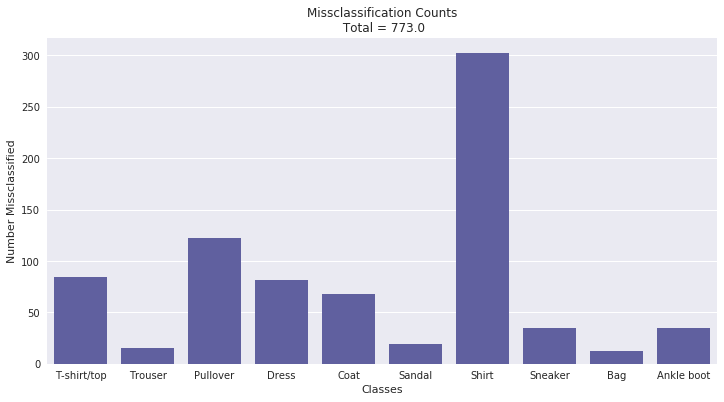

In [17]:
c=cmr['Crosstab'].values
c=c[:,1:].astype('float')

missedCount = []
for i in range(len(c)):
    missed = 0
    for j in range(len(c)):
        if i != j:
            missed = missed + c[i][j]
    missedCount.append(missed)
    
plt.subplots(figsize=(12,6))
ax=sns.barplot(x=class_dict.values(), y=missedCount, color='blue', saturation=0.25)
plt.title('Missclassification Counts\n Total = '+str(np.sum(missedCount)))
plt.xlabel('Classes')
plt.ylabel('Number Missclassified')
plt.show()

##### Plot a confusion matrix

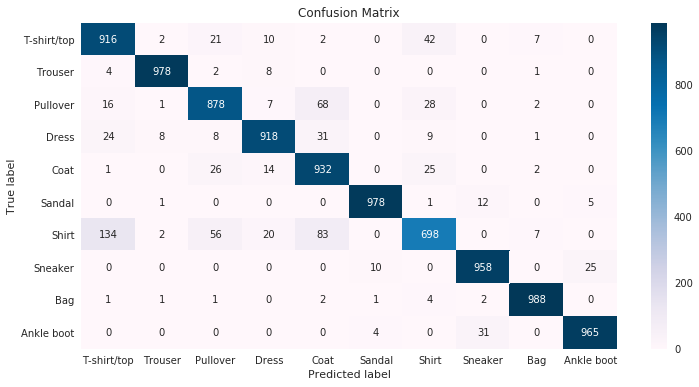

In [18]:
plt.subplots(figsize=(12,6))
ax = sns.heatmap(c,annot=True, fmt="g", cmap='PuBu',
                 yticklabels=class_dict.values(), xticklabels=class_dict.values())
plt.title('Confusion Matrix')
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

Looking above, it’s apparent that our "shirt" class has the highest number of misclassifications and is often times confused for T-shirts/tops, Pullovers, and Coats. We also see that those 3 classes in particular are mostly misclassified as shirts as well. To determine why shirts are so prevelent in cases of misclassification we can look at a few cases correct and incorrect predictions:

1. A few correct predictions at random
2. A few incorrect predictions at random
3. The most correct predictions (those with highest probability that are correct)
4. The most incorrect predictions (those with highest probability that are incorrect)

##### A few correct predictions at random

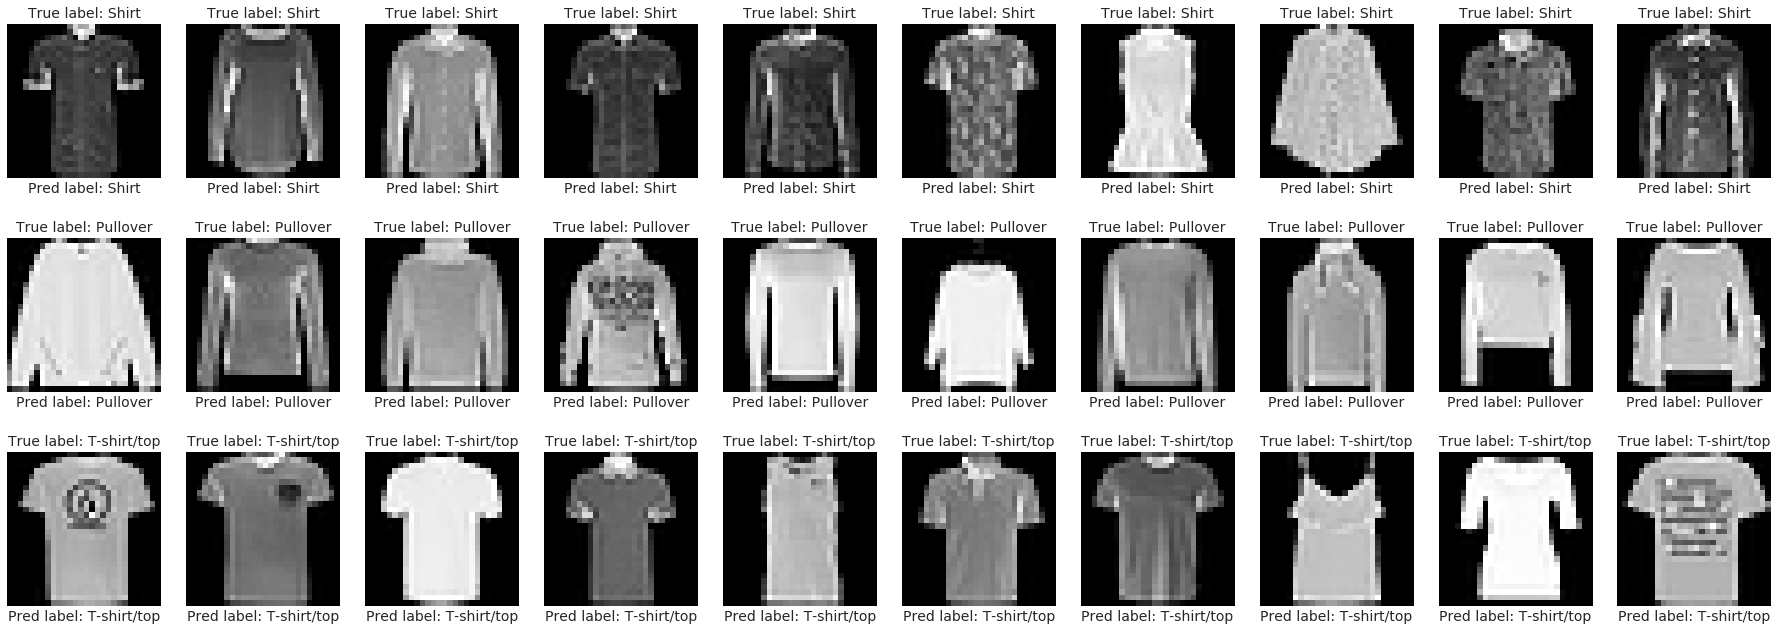

In [19]:
plot_imgs(s.CASTable('lenet_scored'), class_list=[6,2,0], query_condition='_label_ = _DL_PredName_',
          images_per_class=10, figsize=(25,10), font_size=14)

##### A few incorrect predictions at random - classes 6, 2, 0

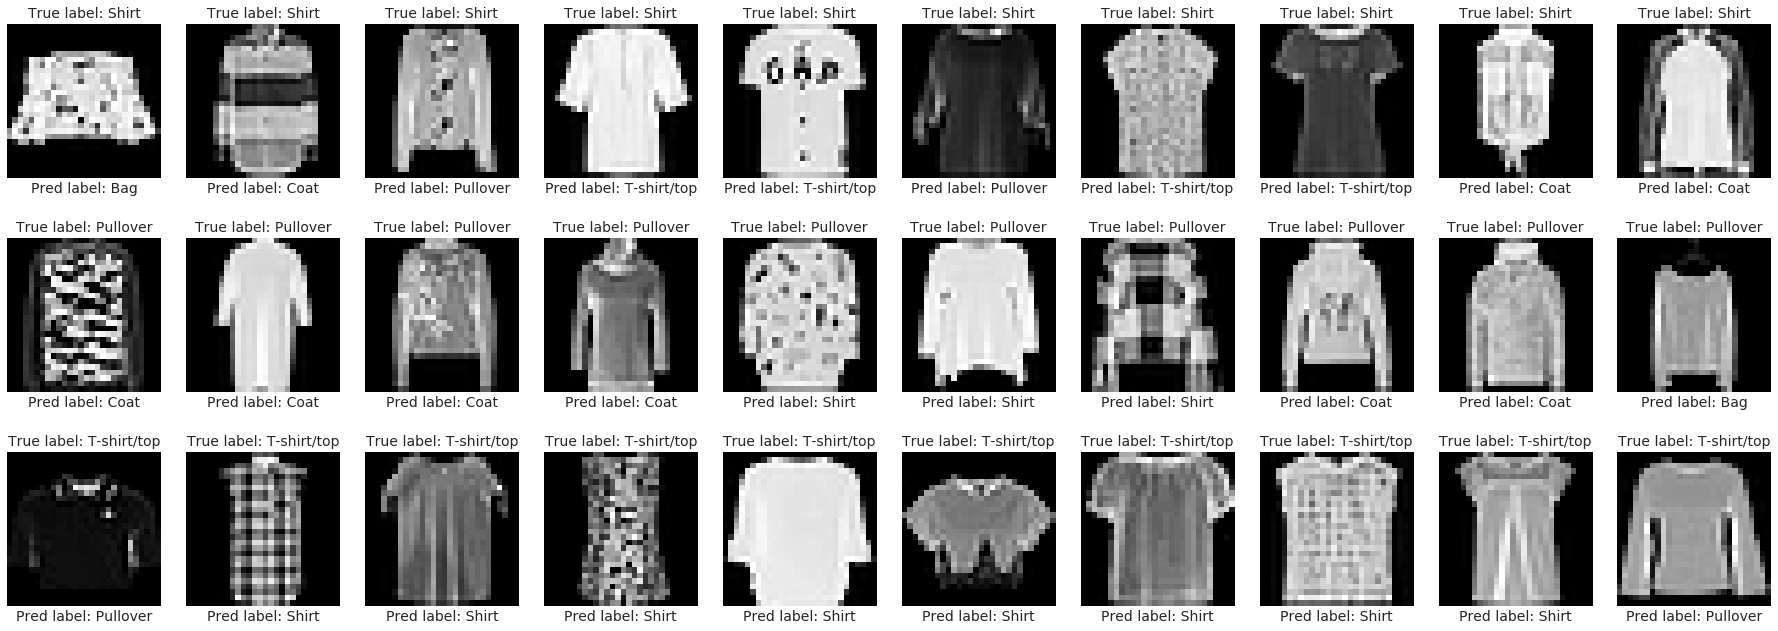

In [20]:
plot_imgs(s.CASTable('lenet_scored'), class_list=[6,2,0], query_condition='_label_ ^= _DL_PredName_',
          images_per_class=10, figsize=(25,10), font_size=14)

#####   The most correct predictions for class6 images

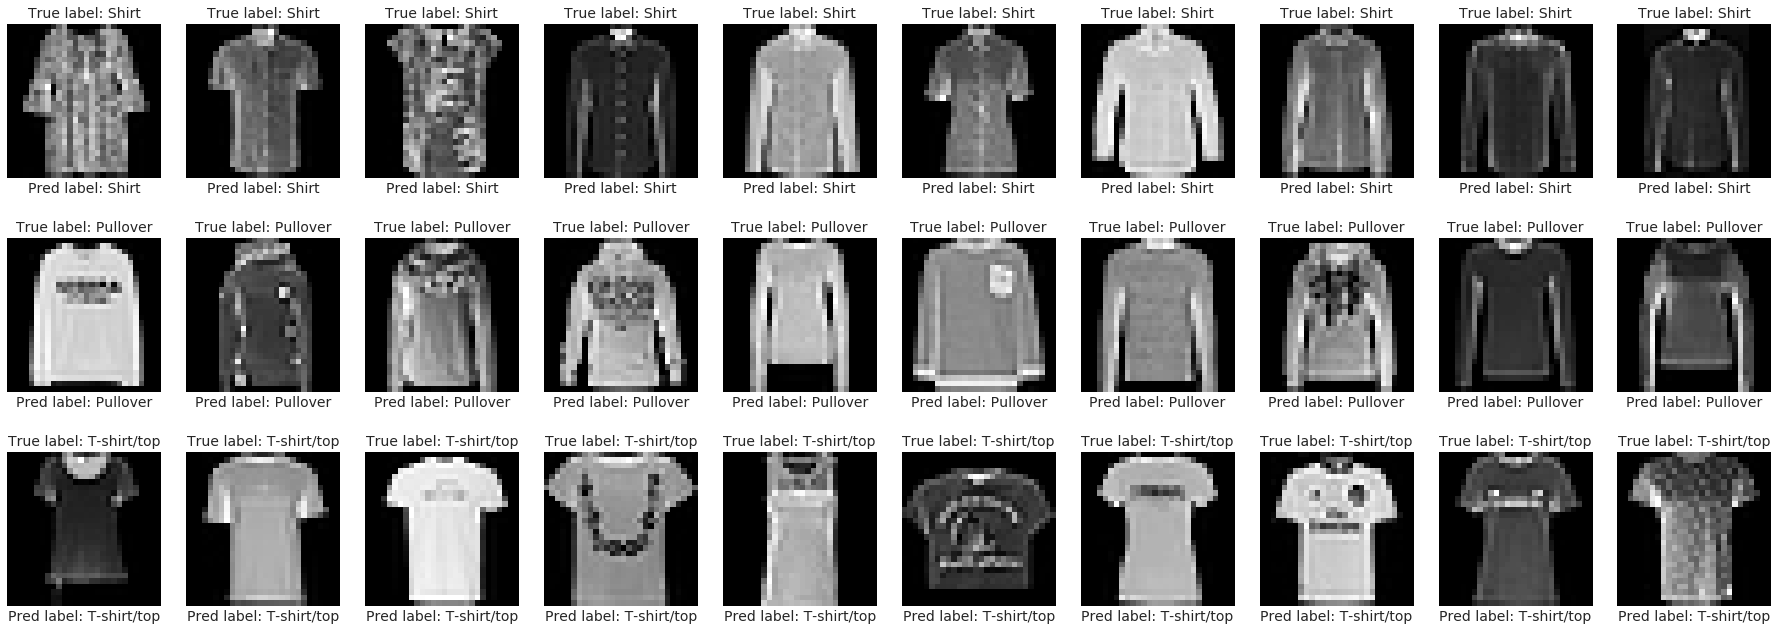

In [21]:
plot_imgs(s.CASTable('lenet_scored'),class_list=[6,2,0], query_condition='_label_ = _DL_PredName_ and _DL_PredP_ > 0.9',
          images_per_class=10, figsize=(25,10),font_size=14)

##### The most incorrect predictions for class6 images

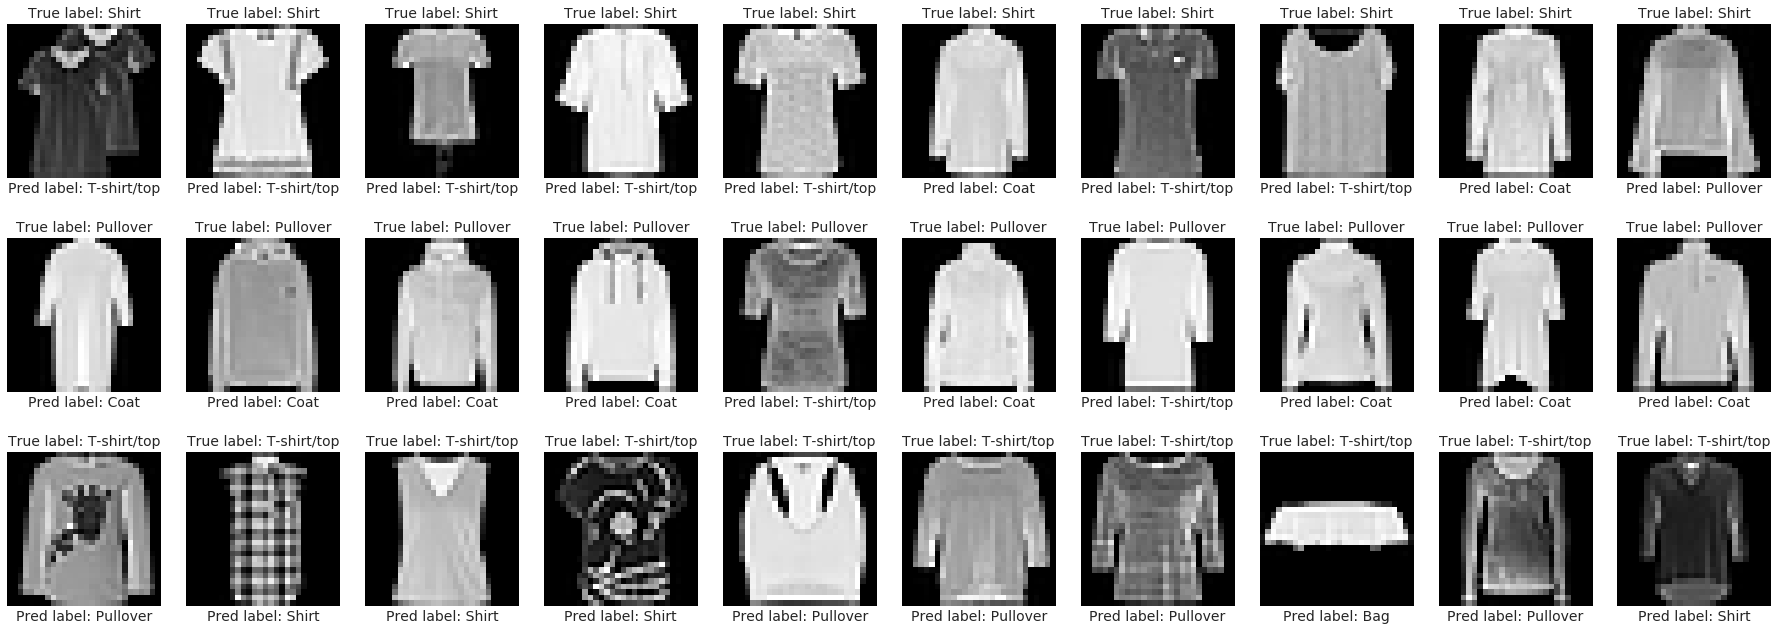

In [22]:
plot_imgs(s.CASTable('lenet_scored'),class_list=[6,2,0], query_condition='_label_ ^= _DL_PredName_ and _DL_PredP_ > 0.9',
          images_per_class=10, figsize=(25,10),font_size=14)

### Conv walk through

In [ ]:
layeroutTbl = s.CASTable('layerout',replace=True)
l_out = layeroutTbl.fetch()['Fetch']

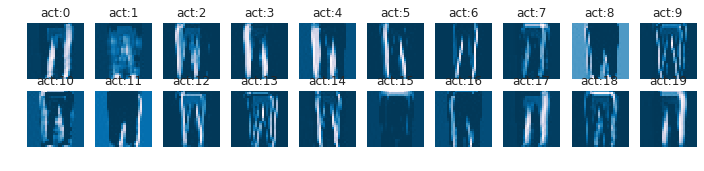

In [24]:
fig=plt.figure(figsize=(12, 6))
for i in range(20):
    w=np.asarray(layeroutTbl.fetchimages(image='_LayerAct_1_IMG_{}_'.format(i))['Images'].iloc[0][0])
    b=fig.add_subplot(5,10,i+1)
    plt.imshow(w, cmap='PuBu_r')
    plt.title('act:{}'.format(i))
    plt.axis('off')

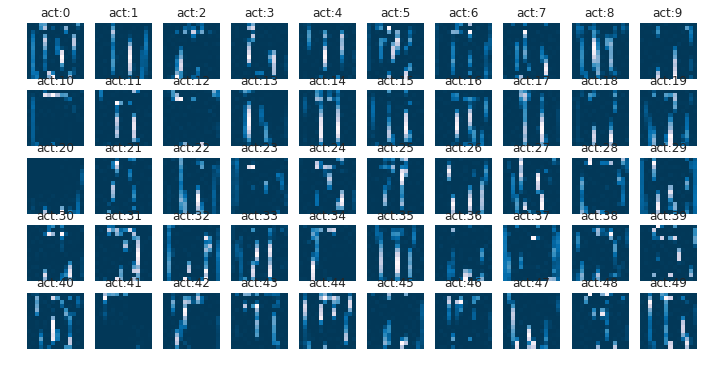

In [25]:
fig=plt.figure(figsize=(12, 6))
for i in range(50):
    w=np.asarray(layeroutTbl.fetchimages(image='_LayerAct_3_IMG_{}_'.format(i))['Images'].iloc[0][0])
    b=fig.add_subplot(5,10,i+1)
    plt.imshow(w, cmap='PuBu_r')
    plt.title('act:{}'.format(i))
    plt.axis('off')

In [26]:
s.endsession()

+ Elapsed: 8.9e-05s, mem: 0.21mb